In [1]:
import ssl

# from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   six.moves import urllib
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
path = 'https://storage.googleapis.com/tf-datasets/titanic'
train_df = pd.read_csv(f'{path}/train.csv')
val_df = pd.read_csv(f'{path}/eval.csv')
y_train = train_df.pop('survived')
y_val = val_df.pop('survived')
train_df.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
train_df.shape, val_df.shape

((627, 9), (264, 9))

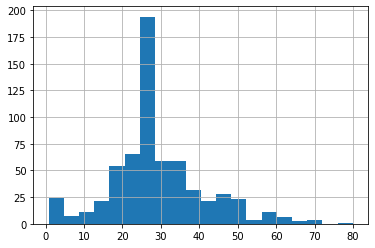

In [6]:
train_df.age.hist(bins=20);

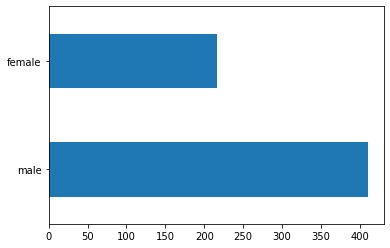

In [7]:
train_df.sex.value_counts().plot(kind='barh');

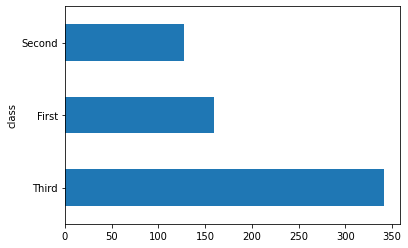

In [8]:
train_df.value_counts('class').plot(kind='barh');

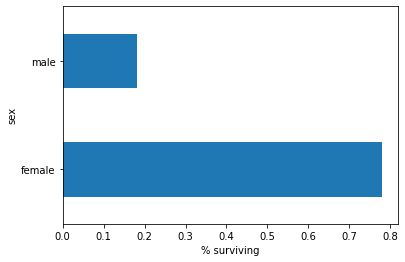

In [9]:
pd.concat([train_df, y_train], axis=1)\
    .groupby('sex')\
    .survived.mean()\
    .plot(kind='barh')\
    .set_xlabel('% surviving');

In [10]:
CATEGORICAL = [
    'sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 
    'alone']
NUMERIC = ['age', 'fare']

In [11]:
feature_cols = []
for col in CATEGORICAL:
    vocab = train_df[col].unique()
    feature_cols.append(
        tf.feature_column.categorical_column_with_vocabulary_list(col, 
                                                                  vocab))
for col in NUMERIC:
    feature_cols.append(
        tf.feature_column.numeric_column(col, dtype=tf.float32))
    
feature_cols

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [12]:
def make_input_f(data_df, label_df, epochs=10, shuffle=True, batch=64):
    
    def input_f():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch).repeat(epochs)
        return ds
    
    return input_f

In [13]:
train_input_f = make_input_f(train_df, y_train)
val_input_f = make_input_f(val_df, y_val, epochs=1, shuffle=False)

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/02/r9r5790n0wz7j9spprbscg100000gp/T/tmpoy9cvs71', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [18]:
linear_est.train(train_input_f)
res = linear_est.evaluate(val_input_f)
print(res['accuracy'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/02/r9r5790n0wz7j9spprbscg100000gp/T/tmpoy9cvs71/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/02/r9r5790n0wz7j9spprbscg100000gp/T/tmpoy9cvs71/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:loss = 0.39431143, step = 200
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...
INFO:tensorflow:Saving checkpoints for 300 into /var/folders/02/r9r5790n0wz7j9spprbscg100000gp/T/tmpoy9cvs71/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...
INFO:tensorflow:Loss for final step: 0.49966323.
IN

In [20]:
fitted = list(linear_est.predict(val_input_f))
fitted[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/02/r9r5790n0wz7j9spprbscg100000gp/T/tmpoy9cvs71/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'logits': array([-2.0214252], dtype=float32),
 'logistic': array([0.1169717], dtype=float32),
 'probabilities': array([0.88302827, 0.1169717 ], dtype=float32),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object)}